In [226]:
import theano
import numpy

from theano import tensor

theano.config.floatX = 'float32'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load model and parameters from vggnet 19

In [227]:
import lasagne
import pickle

from vggnet import build_model
vggnet_model = build_model()

params_val = pickle.load(open('./vgg19.pkl'))
lasagne.layers.set_all_param_values(vggnet_model['pool5'], params_val['param values'][:32])

## Build the network for texture generation

In [228]:
X = tensor.ftensor4('image')

Z_names = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
Zs = dict()
for i in range(5):
    Zs['Z%d' % (i+1,)] = tensor.ftensor4('Z%d' % (i+1,))

In [229]:
from tg_model import build_model

texture_generation_nn = build_model(Zs)
generated_image_graph = lasagne.layers.get_output(texture_generation_nn['output'])

In [230]:
f_texture_generation = theano.function([Zs[n] for n in Z_names], [generated_image_graph])

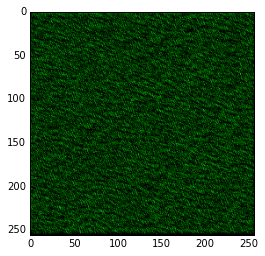

In [231]:
# test texture generation net
theano.config.exception_verbosity = 'low'

def generate_noisy_images(n=1):
    Z1 = numpy.random.rand(n, 1, 256, 256).astype('float32')
    Z2 = numpy.random.rand(n, 1, 128, 128).astype('float32')
    Z3 = numpy.random.rand(n, 1, 64, 64).astype('float32')
    Z4 = numpy.random.rand(n, 1, 32, 32).astype('float32')
    Z5 = numpy.random.rand(n, 1, 16, 16).astype('float32')
    
    return Z1, Z2, Z3, Z4, Z5

Z1, Z2, Z3, Z4, Z5 = generate_noisy_images()

o = f_texture_generation(Z1, Z2, Z3, Z4, Z5)
plt.imshow(numpy.rollaxis(o[0][0], 0, 3)/numpy.max(o[0][0]))

## Load an image

0 255


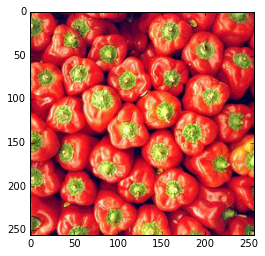

In [232]:
texture_image = mpimg.imread('./red-peppers256.jpg')
plt.imshow(texture_image)

print texture_image.min(), texture_image.max()

## Define Gram matrix

In [233]:
def gram_matrix(X):
    M = X.shape[2]*X.shape[3]
    X = X.flatten(ndim=3)
    return tensor.tensordot(X, X, axes=([2], [2]))/M**2

## Compute texture features for target image

In [234]:
texture_loss_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def texture_features(X):
    layers = [vggnet_model[k] for k in texture_loss_layers]
    outputs = lasagne.layers.get_output(layers, X)
    
    return outputs

In [235]:
texture_image_nn_input = numpy.rollaxis(texture_image, 2)[None]

f_features = theano.function(
        inputs=[X],
        outputs=[gram_matrix(f) for f in texture_features(X)]
)
target_image_features = f_features(texture_image_nn_input)

In [236]:
print target_image_features[0].flatten()

[ 0.04993023  0.0818833   0.04519226 ...,  0.          0.03292895
  0.04422049]


## Define loss function

In [237]:
text_generated = [gram_matrix(f) for f in texture_features(generated_image_graph)]

loss = 0
for i in range(len(target_image_features)):
    loss += (((text_generated[i] - target_image_features[i]) ** 2)).mean()

In [238]:
f_loss = theano.function([Zs[n] for n in Z_names], [loss])

In [239]:
o = f_loss(Z1, Z2, Z3, Z4, Z5)

In [240]:
print o

[array(3572378.230147711)]


In [241]:
f_testoutputgram = theano.function([Zs[n] for n in Z_names], text_generated)

In [242]:
test_gram = f_testoutputgram(Z1, Z2, Z3, Z4, Z5)

print [t.shape for t in test_gram]

[(1, 64, 1, 64), (1, 128, 1, 128), (1, 256, 1, 256), (1, 512, 1, 512), (1, 512, 1, 512)]


In [243]:
f_testoutputfmaps = theano.function(
        inputs=[X],
        outputs=texture_features(X)
)

test_fmaps = f_testoutputfmaps(texture_image_nn_input)

print [t.shape for t in test_fmaps]

[(1, 64, 256, 256), (1, 128, 128, 128), (1, 256, 64, 64), (1, 512, 32, 32), (1, 512, 16, 16)]


In [244]:
print [t.shape for t in target_image_features]

[(1, 64, 1, 64), (1, 128, 1, 128), (1, 256, 1, 256), (1, 512, 1, 512), (1, 512, 1, 512)]


## Learn weights

In [245]:
learning_rate = 0.01
updates = []

parameters = lasagne.layers.get_all_params(texture_generation_nn['output'])
for param in parameters:
    updates.append((param, param - learning_rate*tensor.grad(loss, param)))

In [246]:
f_updates = theano.function(
    [Zs[n] for n in Z_names],
    [loss],
    updates=updates
)

In [247]:
for i in range(100):
    Z1, Z2, Z3, Z4, Z5 = generate_noisy_images(1)
    o = f_updates(Z1, Z2, Z3, Z4, Z5)
    
    print o[0]

3572378.23022
3571381.32345
2.90990025206e+34
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


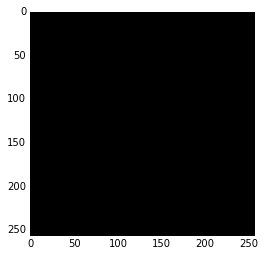

In [248]:
Z1, Z2, Z3, Z4, Z5 = generate_noisy_images(2)

o = f_texture_generation(Z1, Z2, Z3, Z4, Z5)
plt.imshow(numpy.rollaxis(o[0][0], 0, 3)/numpy.max(o[0][0]))